In [540]:
# Import modules we'll need

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [541]:
# Make train and test dataframes
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
train_data['Deck'] = train_data['Cabin'].str[0]

# Let's turn our categorical data into numbers so we can calculate correlation.

train_data.Deck = pd.Categorical(train_data.Deck)
train_data['Deck_Code'] = train_data.Deck.cat.codes

train_data.Sex = pd.Categorical(train_data.Sex)
train_data['Sex_Code'] = train_data.Sex.cat.codes

train_data.Embarked = pd.Categorical(train_data.Embarked)
train_data['Embarked_Code'] = train_data.Embarked.cat.codes

train_data = train_data[['PassengerId','Survived', 'Pclass', 'Sex_Code', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Code', 'Deck_Code']]

train_data.describe()

,PassengerId,Survived,Pclass,Sex_Code,Age,SibSp,Parch,Fare,Embarked_Code,Deck_Code
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,1.529742,-0.223345
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.800254,1.590899
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000,-1.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000,-1.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000,-1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,7.000000


In [542]:
# Check for null values

columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']

for column in list(train_data.columns) :
    print(column + ' is ' + str(round((len(train_data) - train_data[column].count())/len(train_data),4)) + '% NaN.' )

PassengerId is 0.0% NaN.
Survived is 0.0% NaN.
Pclass is 0.0% NaN.
Sex_Code is 0.0% NaN.
Age is 0.1987% NaN.
SibSp is 0.0% NaN.
Parch is 0.0% NaN.
Fare is 0.0% NaN.
Embarked_Code is 0.0% NaN.
Deck_Code is 0.0% NaN.


In [543]:
# Drop rows with nan values as this will make up at most 0.98% Of train data.

train_data = train_data.dropna()
train_data.describe()

,PassengerId,Survived,Pclass,Sex_Code,Age,SibSp,Parch,Fare,Embarked_Code,Deck_Code
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,0.634454,29.699118,0.512605,0.431373,34.694514,1.588235,-0.116246
std,259.119524,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930,0.789963,1.672881
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,222.250000,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000,2.000000,-1.000000
50%,445.000000,0.000000,2.000000,1.000000,28.000000,0.000000,0.000000,15.741700,2.000000,-1.000000
75%,677.750000,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000,2.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,2.000000,7.000000


**Layout of the ship**

After doing some research on the [encyclopedia titanica](https://www.encyclopedia-titanica.org/titanic-deckplans/profile.html) website, we see that the classes, pclasses in our data, generally indicate the location along the major axis of the boat. First class is near the front, third class near the rear, and second class between the two. The cabin numbers indicate the depth of the level on the ship. A cabins are the highest, B cabins are the second highest, etc. It should be noted that the lifeboats were located on the boat deck, above the A deck, and on either side of the ship.

Text(0.5, 1.0, 'Survived Avg Age')

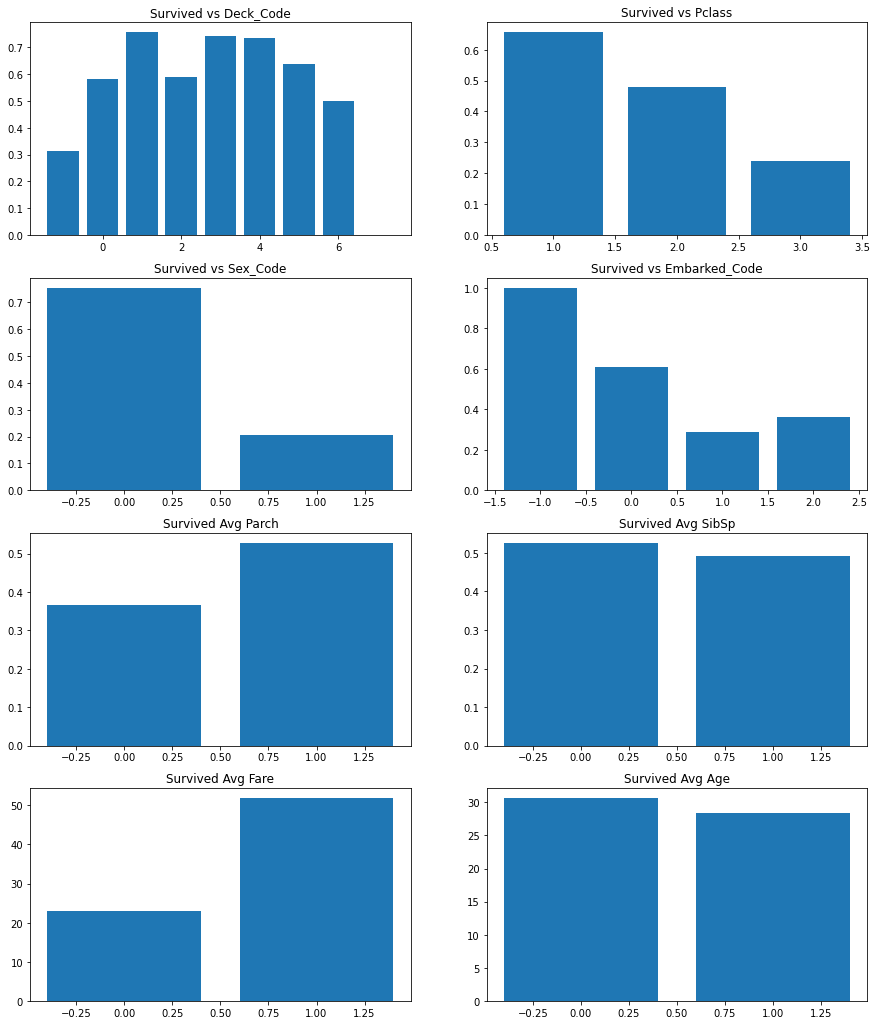

In [544]:
features = ['Pclass', 'Sex_Code', 'Embarked_Code', 'Deck_Code']
fig, axs = plt.subplots(4, 2, figsize=(15,18))


for i in list(range(2)):
    for j in list(range(2)):
        labels = train_data[features[(i*2-1)+j]].unique()
        label_means = []
        for label in labels:
            label_means.append(train_data.loc[train_data[features[(i*2-1)+j]] == label]['Survived'].mean())
        labels_df = pd.DataFrame({
            'labels': labels,
            'label_means': label_means
        }).sort_values(by='label_means')
        axs[i,j].bar(labels_df['labels'], labels_df['label_means'])
        axs[i,j].set_title('Survived vs ' + features[(i*2-1)+j])
        

axs[2,0].bar([0,1], [train_data.loc[train_data['Survived'] == 0]['Parch'].mean(), train_data.loc[train_data['Survived'] == 1]['Parch'].mean()])
axs[2,0].set_title('Survived Avg Parch')
axs[2,1].bar([0,1], [train_data.loc[train_data['Survived'] == 0]['SibSp'].mean(), train_data.loc[train_data['Survived'] == 1]['SibSp'].mean()])
axs[2,1].set_title('Survived Avg SibSp')
axs[3,0].bar([0,1], [train_data.loc[train_data['Survived'] == 0]['Fare'].mean(), train_data.loc[train_data['Survived'] == 1]['Fare'].mean()])
axs[3,0].set_title('Survived Avg Fare')
axs[3,1].bar([0,1], [train_data.loc[train_data['Survived'] == 0]['Age'].mean(), train_data.loc[train_data['Survived'] == 1]['Age'].mean()])
axs[3,1].set_title('Survived Avg Age')

In [545]:
train_data.corr(method='pearson')['Survived']

PassengerId      0.029340
Survived         1.000000
Pclass          -0.359653
Sex_Code        -0.538826
Age             -0.077221
SibSp           -0.017358
Parch            0.093317
Fare             0.268189
Embarked_Code   -0.189979
Deck_Code        0.284396
Name: Survived, dtype: float64

## What columns to focus on
From here, it is clear that the features with strongest correlation with survival are: sex, age, fare, and deck. We'll use these to build our model.

In [546]:
# Before building our train and test dataframes we need to figure out what we're going to replace all those nan values with. 
# Let's see which of the values in the test data are sometimes nan. Remember that deck is calculated from cabin.

check_features = ['Sex', 'Age', 'Fare','Cabin']

test_data['Deck'] = test_data['Cabin'].str[0]

test_data.Deck = pd.Categorical(test_data.Deck)
test_data['Deck_Code'] = test_data.Deck.cat.codes

test_data.Sex = pd.Categorical(test_data.Sex)
test_data['Sex_Code'] = test_data.Sex.cat.codes

# Check for null values

for column in check_features :
    print(column + ' is ' + str(round((len(test_data) - test_data[column].count())/len(test_data),4)) + '% NaN.' )
    


Sex is 0.0% NaN.
Age is 0.2057% NaN.
Fare is 0.0024% NaN.
Cabin is 0.7823% NaN.


In [547]:
# Age and fare will be filled in with their average values while deck code will be determined by the most common value.

age_fill = train_data['Age'].mean()
fare_fill = train_data['Fare'].mean()

train_data.groupby(['Deck_Code']).count()

,PassengerId,Survived,Pclass,Sex_Code,Age,SibSp,Parch,Fare,Embarked_Code
Deck_Code,,,,,,,,,
-1,529,529,529,529,529,529,529,529,529
0,12,12,12,12,12,12,12,12,12
1,45,45,45,45,45,45,45,45,45
2,51,51,51,51,51,51,51,51,51
3,31,31,31,31,31,31,31,31,31
4,30,30,30,30,30,30,30,30,30
5,11,11,11,11,11,11,11,11,11
6,4,4,4,4,4,4,4,4,4
7,1,1,1,1,1,1,1,1,1


In [548]:
deck_fill = 2

In [549]:
# Build our features/targets for training/testing.

final_features = ['Sex_Code', 'Age', 'Fare','Deck_Code']

test_data['Deck'] = test_data['Cabin'].str[0]

test_data.Deck = pd.Categorical(test_data.Deck)
test_data['Deck_Code'] = test_data.Deck.cat.codes.replace(-1,2)

test_data.Sex = pd.Categorical(test_data.Sex)
test_data['Sex_Code'] = test_data.Sex.cat.codes

test_data['Age'] = test_data['Age'].fillna(age_fill)
test_data['Fare'] = test_data['Fare'].fillna(fare_fill)

X_train = train_data[final_features]
Y_train = train_data['Survived']
X_test  = test_data[final_features]
X_train.shape, Y_train.shape, X_test.shape

((714, 4), (714,), (418, 4))

In [550]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_LR = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.01

In [551]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_SVM = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

67.37

In [552]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_KNN = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

82.49

In [553]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_GNB = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

78.01

In [554]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_P = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

59.38

In [555]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred_LSVC = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77.45

In [556]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred_SGD = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

39.78

In [557]:
#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('my_submission.csv', index=False)

In [558]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_DT = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

98.88

In [559]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_RF = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.88

In [560]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,98.88
8,Decision Tree,98.88
1,KNN,82.49
2,Logistic Regression,78.01
4,Naive Bayes,78.01
7,Linear SVC,77.45
0,Support Vector Machines,67.37
5,Perceptron,59.38
6,Stochastic Gradient Decent,39.78


In [564]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred_RF})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
